In [1]:
import math
import random
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score, confusion_matrix

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
PATH='data/defective-products//'
data = pd.read_csv(f'{PATH}molding_A_20171030.csv')
print(data.shape)

(40688, 60)


## Data Analysis

In [3]:
data['RESULT_QUALITY'].unique()

array(['Good', 'ColorUnevenness', 'Short', 'Mera'], dtype=object)

In [4]:
data.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness      440
Good               40164
Mera                  19
Short                 65
Name: No, dtype: int64

In [5]:
data.dtypes[:8]

No                  int64
RESULT_QUALITY     object
INDT               object
R_SHTCNT            int64
R_DIECD            object
R_SHTCYCTM        float64
R_SHTDRYTM        float64
R_SHTPHTIM        float64
dtype: object

In [6]:
# Understand data
# data.groupby(['RESULT_QUALITY']).describe().T

In [7]:
data['R_DIECD'].unique()

array(['Molding_A'], dtype=object)

In [8]:
# drop unnessary attributes: INDT - timeline, R_DIECD - only 1 molding_A
data.drop(['R_DIECD', 'INDT'], axis=1, inplace=True)

### Missing measure analysis

In [9]:
# We check if data contains any missing values
c = data.count()
c[c!=40688] # len of dataset is 40688

R_SHTPGETTM      10399
R_SHTHTR01TMP    34056
R_SHTHTR02TMP    34056
R_SHTROLCNT      10399
R_SHTROLMAX      10399
R_SHTCOLTM       10399
R_SHTKPTM        10399
R_SHTFINPT       10399
dtype: int64

There are 2 groups of missing values with 34056 & 10399 non-missing values respectively

In [10]:
group1 = ['R_SHTHTR01TMP', 'R_SHTHTR02TMP']
group2 = ['R_SHTPGETTM', 'R_SHTROLCNT', 'R_SHTROLMAX', 
          'R_SHTCOLTM', 'R_SHTKPTM', 'R_SHTFINPT']

In [11]:
# GROUP 1
nan = data[data['R_SHTHTR01TMP'].isnull()]
print(nan.groupby(['RESULT_QUALITY']).count().iloc[:, 0])
print('Min, Max values: ', nan['No'].min(), nan['No'].max())

RESULT_QUALITY
ColorUnevenness      74
Good               6536
Mera                  4
Short                18
Name: No, dtype: int64
Min, Max values:  7452 14083


Dataset is in chronological order.<br>
R_SHTHTR01TMP && R_SHTHTR02TMP are missing values from 7452 to 14083 which is in range between 1 and 40688 <br>
=> The missing value due to <strong>the broken of sensor</strong>. I will replace missing value with mean of their group

In [12]:
exits = data[data['R_SHTHTR01TMP'].notnull()]
group_mean = exits.mean()[group1]
for c in group1:
    data.loc[data[c].isnull(), c] = group_mean[c]

In [13]:
# GROUP 2
nan = data[data['R_SHTPGETTM'].isnull()]
print(nan.groupby(['RESULT_QUALITY']).count().iloc[:, 0])
print('Min, Max values: ', nan['No'].min(), nan['No'].max())

RESULT_QUALITY
ColorUnevenness      292
Good               29953
Mera                  16
Short                 28
Name: No, dtype: int64
Min, Max values:  1 30289


It seems that <strong>additional sensors</strong> were added from items 30290 to increase anlysis power. 

In [14]:
exits = data[data['R_SHTPGETTM'].notnull()]
print(exits.groupby(['RESULT_QUALITY']).count().iloc[:, 0])
print('Min, Max values: ', exits['No'].min(), exits['No'].max())
exits.groupby('RESULT_QUALITY').std()[group2].T

RESULT_QUALITY
ColorUnevenness      148
Good               10211
Mera                   3
Short                 37
Name: No, dtype: int64
Min, Max values:  30290 40688


RESULT_QUALITY,ColorUnevenness,Good,Mera,Short
R_SHTPGETTM,1.571926,1.600190,0.017321,0.126972
R_SHTROLCNT,0.000000,0.000000,0.000000,0.000000
R_SHTROLMAX,4.522680,4.901303,0.577350,4.946865
R_SHTCOLTM,0.000000,0.000000,0.000000,0.000000
R_SHTKPTM,0.000000,0.000000,0.000000,0.000000
R_SHTFINPT,0.000000,0.000000,0.000000,0.000000


4 out of 6 additional columns have <strong>standard deviations of 0</strong> => need to investigate

In [15]:
# Get small sample to confirm our deduction
group2_idx = [data.columns.get_loc(c) for c in data.columns if c in group2]
data.iloc[35000:35008, group2_idx]

,R_SHTPGETTM,R_SHTROLCNT,R_SHTROLMAX,R_SHTCOLTM,R_SHTKPTM,R_SHTFINPT
35000,4.13,142.0,87.0,11.0,5.0,187.0
35001,4.10,142.0,76.0,11.0,5.0,187.0
35002,4.17,142.0,81.0,11.0,5.0,187.0
35003,4.14,142.0,81.0,11.0,5.0,187.0
35004,4.14,142.0,83.0,11.0,5.0,187.0
35005,4.16,142.0,77.0,11.0,5.0,187.0
35006,4.16,142.0,78.0,11.0,5.0,187.0
35007,4.13,142.0,76.0,11.0,5.0,187.0


Values are exactly the same => maybe those sensors are not working or those are irrelevant in our analysis.

Because there are only 10.000/40.000 data have additional 6 sensors, in which 4 of them are irrelevant. To make the analysis concise, I will remove those additional sensors data. Analysis with those sensors will be carry out when more data is collected.

In [16]:
data.drop(group2, axis=1, inplace=True)
# Remove index column
data.drop(['No'], axis=1, inplace=True)

## Save processed data

In [17]:
data['RESULT_QUALITY'] = data['RESULT_QUALITY'].astype('category').cat.as_ordered()

In [18]:
data.shape

(40688, 51)

In [19]:
data.to_feather('data/defective-products/process_data.f')

In [20]:
data = pd.read_feather('data/defective-products/process_data.f')

## Balance Sample

In [21]:
data.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness      440
Good               40164
Mera                  19
Short                 65
Name: R_SHTCNT, dtype: int64

In [22]:
features, labels = data.iloc[:, 1:], data['RESULT_QUALITY']
# Encoding labels
le = preprocessing.LabelEncoder()
labels = le.fit_transform(labels)

# Convert to numpy
features = np.asarray(features)
labels = np.asarray(labels)
print(features.shape)
print(labels.shape)

(40688, 50)
(40688,)


To split data, we do not use train_test_split, which give us random selection.
We use <strong>Stratified Split</strong> which choose data propotionally and randomly in each data group

In [23]:
def split_data(X, y=None, n_splits=4):
    skf = model_selection.StratifiedKFold(n_splits=n_splits, shuffle=True)
    
    train_index, test_index = next(skf.split(X, y))
    print("TRAIN:", train_index.shape, "TEST:", test_index.shape)
    X_train, X_test = features[train_index], features[test_index]
    y_train, y_test = labels[train_index], labels[test_index]
    
    return train_index, test_index, X_train, X_test, y_train, y_test

# Splitting
trn_idx, test_idx, X_train, X_test, y_train, y_test = split_data(features, labels, n_splits=3)

TRAIN: (27124,) TEST: (13564,)


In [24]:
unique, counts = np.unique(y_train, return_counts=True)
dict(zip(unique, counts))

{0: 293, 1: 26776, 2: 12, 3: 43}

In [25]:
unique, counts = np.unique(y_test, return_counts=True)
dict(zip(unique, counts))

{0: 147, 1: 13388, 2: 7, 3: 22}

We can see that our data is imbalance: most items are goods, and rarely and items are Mera, ColorUneveness, Short. We apply <strong>Undersampling</strong> - reduce Good products (choose a portion of it) and <strong>Oversampling</strong> - copying defective products. We <strong>only</strong> apply it to <strong>train data</strong><br><br>
We are going to build multiple samples: each have approximately 1000 good products, 500 ColorUneveness, 500 Mera, 500 Short. We will create <strong>10 samples</strong> and average the results for each type of ML Algorithms

In [26]:
test = data.iloc[test_idx, :]
test.reset_index(drop=True, inplace=True)

In [27]:
trn = data.iloc[trn_idx, :]
trn.reset_index(drop=True, inplace=True)
trn.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness      293
Good               26776
Mera                  12
Short                 43
Name: R_SHTCNT, dtype: int64

In [28]:
n_color = 500//293
n_mera = 500//12
n_short = 500//43

In [29]:
items_good = trn[trn['RESULT_QUALITY']=='Good']
items_color = trn[trn['RESULT_QUALITY']=='ColorUnevenness']
items_mera = trn[trn['RESULT_QUALITY']=='Mera']
items_short = trn[trn['RESULT_QUALITY']=='Short']

In [30]:
trn = trn.append([items_color]*n_color,ignore_index=True)
trn = trn.append([items_mera]*n_mera,ignore_index=True)
trn = trn.append([items_short]*n_short,ignore_index=True)

In [31]:
trn.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness      586
Good               26776
Mera                 504
Short                516
Name: R_SHTCNT, dtype: int64

In [32]:
idx = (trn['RESULT_QUALITY']=='ColorUnevenness') \
        | (trn['RESULT_QUALITY']=='Mera') \
        | (trn['RESULT_QUALITY']=='Short')

idx_errors = trn[idx].index.values
idx_errors

array([  553,   554,   743, ..., 28379, 28380, 28381])

In [33]:
n_sample = 10
samples = []
for i in range(n_sample):
    sample = items_good.sample(n=1000)
    sample = sample.append(trn.iloc[idx_errors])
    samples.append(sample)

In [34]:
print('Number of samples:', len(samples))
samples[0].groupby(['RESULT_QUALITY']).count().iloc[:, 0]

Number of samples: 10


RESULT_QUALITY
ColorUnevenness     586
Good               1000
Mera                504
Short               516
Name: R_SHTCNT, dtype: int64

## ML Algorithms

Because the TARGET is to "analyze which variable affects defective product generation for <strong>EACH</strong> type of defective product". We are going to evaluate each type of defectives SEPARATEDLY

In [35]:
DEBUG = True # False if we don't want to show process of parameter selection during training

In [36]:
test.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness      147
Good               13388
Mera                   7
Short                 22
Name: R_SHTCNT, dtype: int64

Because the test set data is also imbalanced => we don't use Accuracy metrics, but use F1-score metrics instead.
To reduce imbalanced data, we pick only 1000 good items

In [37]:
idx = (test['RESULT_QUALITY']=='ColorUnevenness') \
        | (test['RESULT_QUALITY']=='Mera') \
        | (test['RESULT_QUALITY']=='Short')

idx_errors = test[idx].index.values
test = test[test['RESULT_QUALITY']=='Good'].sample(n=1000).append(test.iloc[idx_errors])

In [38]:
test.groupby(['RESULT_QUALITY']).count().iloc[:, 0]

RESULT_QUALITY
ColorUnevenness     147
Good               1000
Mera                  7
Short                22
Name: R_SHTCNT, dtype: int64

In [39]:
feature_names = np.asarray(test.columns[1:])
n_features = feature_names.shape[0]

### <strong>Support functions</strong>

In [40]:
# Get list of sample contains only 1 type of defective
def separate_data(train, test, defective):
    # Test
    index = (test['RESULT_QUALITY']=='Good') | (test['RESULT_QUALITY']==defective)
    t = test[index]
    X_test, y_test = np.asarray(t.iloc[:, 1:]), np.asarray(t.iloc[:, 0])
    le = preprocessing.LabelEncoder()
    y_test = le.fit_transform(y_test)

    unique, counts = np.unique(y_test, return_counts=True)
    print("test size", dict(zip(unique, counts)))

    # Train
    i_samples = []
    for s in train:
        index = (s['RESULT_QUALITY']=='Good') | (s['RESULT_QUALITY']==defective)
        sample = s[index]
        f, l = np.asarray(sample.iloc[:, 1:]), np.asarray(sample.iloc[:, 0])
        l = le.transform(l)
        i_samples.append((f, l))
    unique, counts = np.unique(i_samples[0][1], return_counts=True)
    print("train size", dict(zip(unique, counts)))
    
    return i_samples, X_test, y_test

#### <strong> F1 score </strong>
Average over multiple examples

In [ ]:
def find_avg_score(model, i_samples, X_test, y_test):
    # Find average score over multiple samples
    scores = []
    for X_train, y_train in i_samples:
        scaler = preprocessing.StandardScaler().fit(X_train)
        X_train_scaled = scaler.transform(X_train)
        X_test_scaled = scaler.transform(X_test)

        # Find F1 Score
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        score = f1_score(y_test, y_pred)
        scores.append(score)

    avg_score = np.average(np.asarray(scores))
    return avg_score

In [ ]:
def plot_heatmap(results, x_param, y_param, x_name, y_name):
    x_len = len(x_param)
    y_len = len(y_param)
    scale = 1.5
    
    results = np.asarray(results).reshape(y_len, x_len)
    f, ax = plt.subplots(1, 1, figsize=(x_len*scale, y_len*scale))
    ax = sns.heatmap(results, annot=True, fmt=".4f", xticklabels=x_param, yticklabels=y_param, cmap="RdPu")
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.set_title("Heatmap - GridSearch", {'fontsize': 16, 'fontweight': 500})

def interprete_confusion(i_samples, model, y_test, defective):
    confusion = None
    X_train = np.asarray([])
    for X, _ in i_samples:
        if len(X_train):
            X_train = np.concatenate((X_train, X))
        else:
            X_train = X
            
    scaler = preprocessing.StandardScaler().fit(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    y_pred = model.predict(X_test_scaled)
    
    confusion = confusion_matrix(y_test, y_pred)
    print("Confusion matrix:\n", confusion)
    print("Total wrong prediction:", confusion[0][1] + confusion[1][0])
    
    print("Predict", defective, "but it is Good items:", confusion[1][0])
    print("Predict Good, but it is", defective, "items:", confusion[0][1])

In [42]:
def plot_feature_importance(n_features, feature_names, weights):
    plt.figure(figsize=(15,10))
    plt.bar(range(n_features), weights, align='center')
    plt.xticks(np.arange(n_features), feature_names, rotation=90)
    plt.xlabel("Feature")
    plt.ylabel("Feature weights / importance")

def display_information(results, x_param, y_param, x_name, y_name, 
                        samples, best_params, best_score, best_model):
    plot_heatmap(results, x_param, y_param, x_name, y_name)
    print("Best params: ", best_params)
    print("Best Test Score", best_score, "\n")

    # Interprete results
    if hasattr(best_model, "coef_"):
        weights = best_model.coef_.reshape(50)
    else:
        weights = best_model.feature_importances_
    
    top_features = feature_names[np.absolute(weights).argsort()[-5:]]

    interprete_confusion(samples, best_model, y_test, defective)
    plot_feature_importance(n_features, feature_names, weights)

    print("\nTop 5 features:", top_features)
    return top_features

def plot_hist(data, defective, index, n_bins=80):
    n = len(index)
    fig, axes = plt.subplots(math.ceil((n+1)//2), 2, figsize=(15, 2 * n))
    defective_items = data[data['RESULT_QUALITY']==defective]
    good_items = data[data['RESULT_QUALITY']=='Good']

    ax = axes.ravel()

    for i, idx in enumerate(index):
        _, bins = np.histogram(data.iloc[:, idx], bins=n_bins)
        ax[i].hist(defective_items.iloc[:, idx], bins=bins, color='red', density=True)
        ax[i].hist(good_items.iloc[:, idx], bins=bins, color='blue', alpha=0.5, density=True)
        ax[i].set_title(data.columns[idx])
        ax[i].set_yticks(())
    ax[0].set_xlabel("Value")
    ax[0].set_ylabel("Frequency")
    ax[0].legend([defective, 'Good'], loc="best")
    fig.tight_layout()

### <strong>Supporting models</strong>

In [43]:
from sklearn.linear_model import LogisticRegression

def lr_model(samples, X_test, y_test):
    param_solver = ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']
    param_C = np.arange(1, 5, 1, dtype=np.int32)
    param_C = np.arange(1, 5, 1, dtype=np.int32)
    x_name, y_name = "C", "solver"

    results = []

    for solver in param_solver:
        for C in param_C:
            # Customize model
            params = {y_name: solver, x_name: C}
            if DEBUG: print(params)

            model = LogisticRegression(C=C, solver=solver, max_iter=5000, n_jobs=-1)

            # Find best model
            avg_score = find_avg_score(model, samples, X_test, y_test)
            results.append(avg_score)

            if avg_score >= max(results):
                best_model = model
                best_score = avg_score
                best_params = params
    
    top_features = display_information(results, param_C, param_solver, x_name, y_name, 
                                       samples, best_params, best_score, best_model)
    
    return best_model, top_features

In [44]:
from sklearn.ensemble import RandomForestClassifier

def rf_model(samples, X_test, y_test):
    param_n = np.arange(15, 40, 5)
    param_depth = np.arange(13, 21, 2)

    x_name, y_name = "depth", "n"
    results = []

    for n in param_n:
        for depth in param_depth:
            # Customize model
            params = {y_name: n, x_name: depth}
            if DEBUG: print(params)

            model = RandomForestClassifier(n_estimators=n, max_depth=depth, n_jobs=-1)

            # Find best model
            avg_score = find_avg_score(model, samples, X_test, y_test)
            results.append(avg_score)

            if avg_score >= max(results):
                best_model = model
                best_score = avg_score
                best_params = params

    top_features = display_information(results, param_depth, param_n, x_name, y_name, 
                                       samples, best_params, best_score, best_model)
    
    return best_model, top_features

In [45]:
from sklearn.linear_model import SGDClassifier

def sgd_model(samples, X_test, y_test):
    param_alpha = np.geomspace(0.0001, 1, 5)
    param_average = np.arange(3, 15, step=2)

    x_name, y_name = "average", "lr"
    results = []

    for alpha in param_alpha:
        for average in param_average:
            # Customize model
            params = {y_name: alpha, x_name: average}
            if DEBUG: print(params)

            model = SGDClassifier(alpha=alpha, average=average, n_jobs=-1, max_iter=1000)

            # Find best model
            avg_score = find_avg_score(model, samples, X_test, y_test)
            results.append(avg_score)

            if avg_score >= max(results):
                best_model = model
                best_score = avg_score
                best_params = params

    top_features = display_information(results, param_average, param_alpha, x_name, y_name, 
                                       samples, best_params, best_score, best_model)
    return best_model, top_features

In [46]:
from sklearn.svm import LinearSVC

def svc_model(samples, X_test, y_test):
    param_C = np.geomspace(0.001, 10, 5)
    param_penalty = ['l2', 'l1']

    x_name, y_name = "C", "penalty"
    results = []

    for penalty in param_penalty:
        for C in param_C:
            # Customize model
            params = {y_name: penalty, x_name: C}
            if DEBUG: print(params)

            model = LinearSVC(C=C, penalty=penalty, max_iter=3000, dual=False)

            # Find best model
            avg_score = find_avg_score(model, samples, X_test, y_test)
            results.append(avg_score)

            if avg_score >= max(results):
                best_model = model
                best_score = avg_score
                best_params = params

    top_features = display_information(results, param_C, param_penalty, x_name, y_name, 
                                       samples, best_params, best_score, best_model)
    return best_model, top_features

### <strong>ColorUnevenness</strong>

In [48]:
important_features = []
defective = 'ColorUnevenness'
i_samples, X_test, y_test = separate_data(samples, test, defective)

test size {0: 147, 1: 1000}
train size {0: 586, 1: 1000}


#### <strong>LogisticRegression<strong>

{'solver': 'newton-cg', 'C': 1}
{'solver': 'newton-cg', 'C': 2}
{'solver': 'newton-cg', 'C': 3}
{'solver': 'newton-cg', 'C': 4}
{'solver': 'lbfgs', 'C': 1}
{'solver': 'lbfgs', 'C': 2}
{'solver': 'lbfgs', 'C': 3}
{'solver': 'lbfgs', 'C': 4}
{'solver': 'sag', 'C': 1}
{'solver': 'sag', 'C': 2}
{'solver': 'sag', 'C': 3}
{'solver': 'sag', 'C': 4}
{'solver': 'saga', 'C': 1}
{'solver': 'saga', 'C': 2}
{'solver': 'saga', 'C': 3}
{'solver': 'saga', 'C': 4}
{'solver': 'liblinear', 'C': 1}


/home/nguyendinhtung/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


{'solver': 'liblinear', 'C': 2}
{'solver': 'liblinear', 'C': 3}
{'solver': 'liblinear', 'C': 4}
Best params:  {'solver': 'saga', 'C': 1}
Best Test Score 0.9824554687594025 

Confusion matrix:
 [[144   3]
 [ 33 967]]
Total wrong prediction: 36
Predict ColorUnevenness but it is Good items: 33
Predict Good, but it is ColorUnevenness items: 3

Top 5 features: ['R_SHTCYL2TMP' 'R_SHTDRYTM' 'R_SHTCYL3TMP' 'R_SHTCNT' 'R_SHTCYL5TMP']


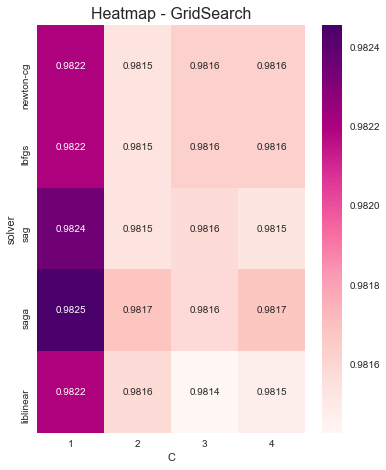

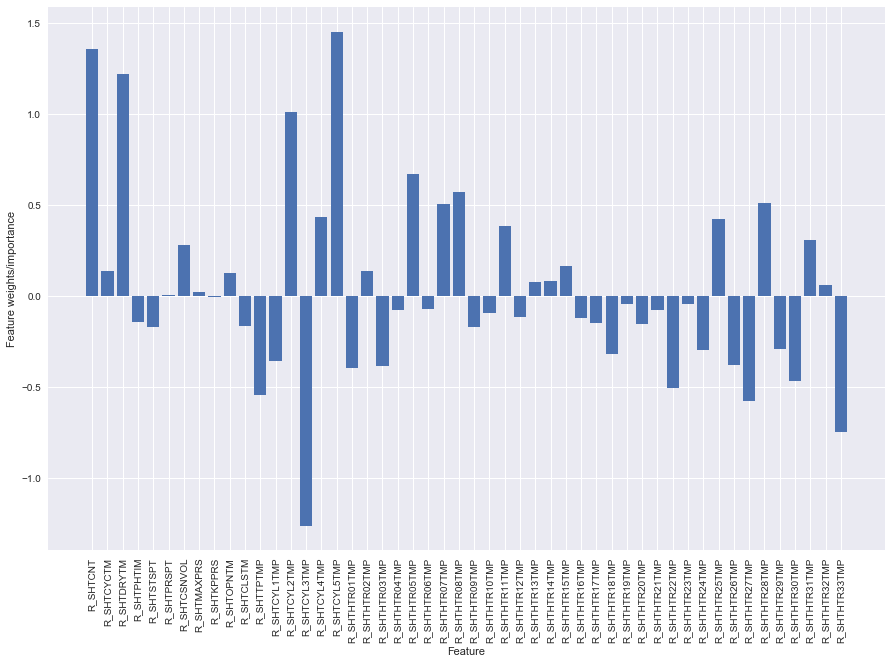

In [49]:
lr, top_features = lr_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>Decision Tree </strong>

{'n': 15, 'depth': 13}
{'n': 15, 'depth': 15}
{'n': 15, 'depth': 17}
{'n': 15, 'depth': 19}
{'n': 20, 'depth': 13}
{'n': 20, 'depth': 15}
{'n': 20, 'depth': 17}
{'n': 20, 'depth': 19}
{'n': 25, 'depth': 13}
{'n': 25, 'depth': 15}
{'n': 25, 'depth': 17}
{'n': 25, 'depth': 19}
{'n': 30, 'depth': 13}
{'n': 30, 'depth': 15}
{'n': 30, 'depth': 17}
{'n': 30, 'depth': 19}
{'n': 35, 'depth': 13}
{'n': 35, 'depth': 15}
{'n': 35, 'depth': 17}
{'n': 35, 'depth': 19}
Best params:  {'n': 35, 'depth': 19}
Best Test Score 0.9833349455264762 

Confusion matrix:
 [[145   2]
 [ 33 967]]
Total wrong prediction: 35
Predict ColorUnevenness but it is Good items: 33
Predict Good, but it is ColorUnevenness items: 2

Top 5 features: ['R_SHTHTR27TMP' 'R_SHTCYL2TMP' 'R_SHTDRYTM' 'R_SHTCYL5TMP' 'R_SHTCNT']


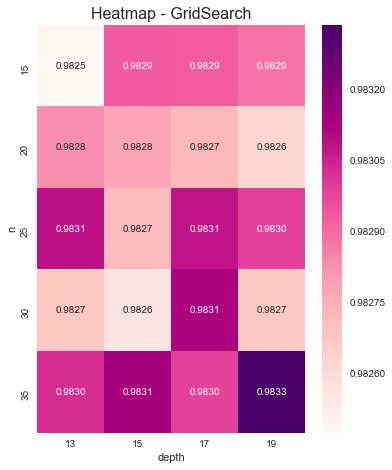

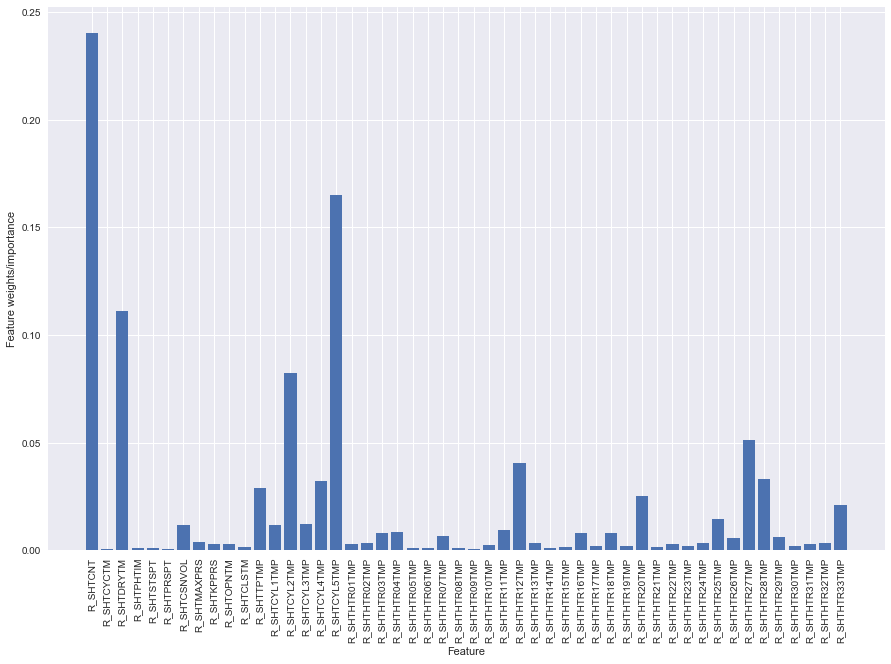

In [50]:
rf, top_features = rf_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>SGD Classifier</strong>

{'lr': 0.0001, 'average': 3}
{'lr': 0.0001, 'average': 5}
{'lr': 0.0001, 'average': 7}
{'lr': 0.0001, 'average': 9}
{'lr': 0.0001, 'average': 11}
{'lr': 0.0001, 'average': 13}
{'lr': 0.001, 'average': 3}
{'lr': 0.001, 'average': 5}
{'lr': 0.001, 'average': 7}
{'lr': 0.001, 'average': 9}
{'lr': 0.001, 'average': 11}
{'lr': 0.001, 'average': 13}
{'lr': 0.01, 'average': 3}
{'lr': 0.01, 'average': 5}
{'lr': 0.01, 'average': 7}
{'lr': 0.01, 'average': 9}
{'lr': 0.01, 'average': 11}
{'lr': 0.01, 'average': 13}
{'lr': 0.1, 'average': 3}
{'lr': 0.1, 'average': 5}
{'lr': 0.1, 'average': 7}
{'lr': 0.1, 'average': 9}
{'lr': 0.1, 'average': 11}
{'lr': 0.1, 'average': 13}
{'lr': 1.0, 'average': 3}
{'lr': 1.0, 'average': 5}
{'lr': 1.0, 'average': 7}
{'lr': 1.0, 'average': 9}
{'lr': 1.0, 'average': 11}
{'lr': 1.0, 'average': 13}
Best params:  {'lr': 0.0001, 'average': 7}
Best Test Score 0.9824005102564408 

Confusion matrix:
 [[144   3]
 [ 33 967]]
Total wrong prediction: 36
Predict ColorUnevenness b

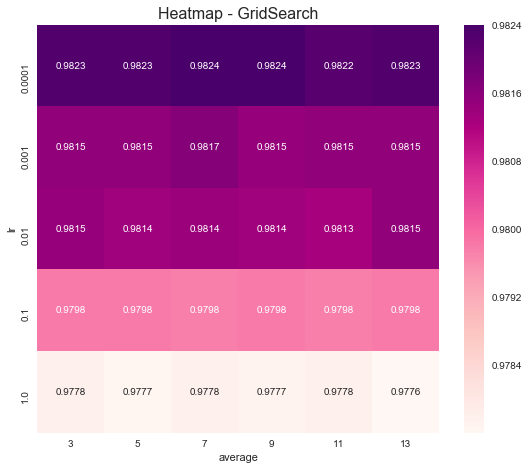

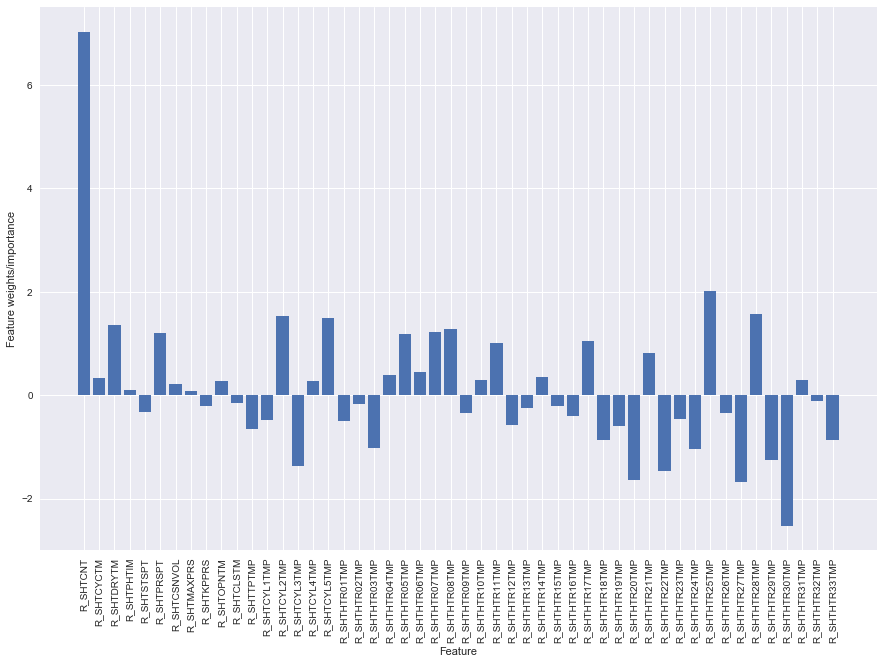

In [51]:
sgd, top_features = sgd_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>LinearSVC</strong>

{'penalty': 'l2', 'C': 0.001}
{'penalty': 'l2', 'C': 0.01}
{'penalty': 'l2', 'C': 0.1}
{'penalty': 'l2', 'C': 1.0}
{'penalty': 'l2', 'C': 10.0}
{'penalty': 'l1', 'C': 0.001}
{'penalty': 'l1', 'C': 0.01}
{'penalty': 'l1', 'C': 0.1}
{'penalty': 'l1', 'C': 1.0}
{'penalty': 'l1', 'C': 10.0}
Best params:  {'penalty': 'l1', 'C': 1.0}
Best Test Score 0.9815701001260516 

Confusion matrix:
 [[144   3]
 [ 36 964]]
Total wrong prediction: 39
Predict ColorUnevenness but it is Good items: 36
Predict Good, but it is ColorUnevenness items: 3

Top 5 features: ['R_SHTCYL3TMP' 'R_SHTCYL5TMP' 'R_SHTHTR20TMP' 'R_SHTHTR30TMP' 'R_SHTCNT']


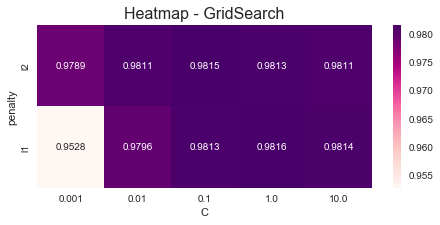

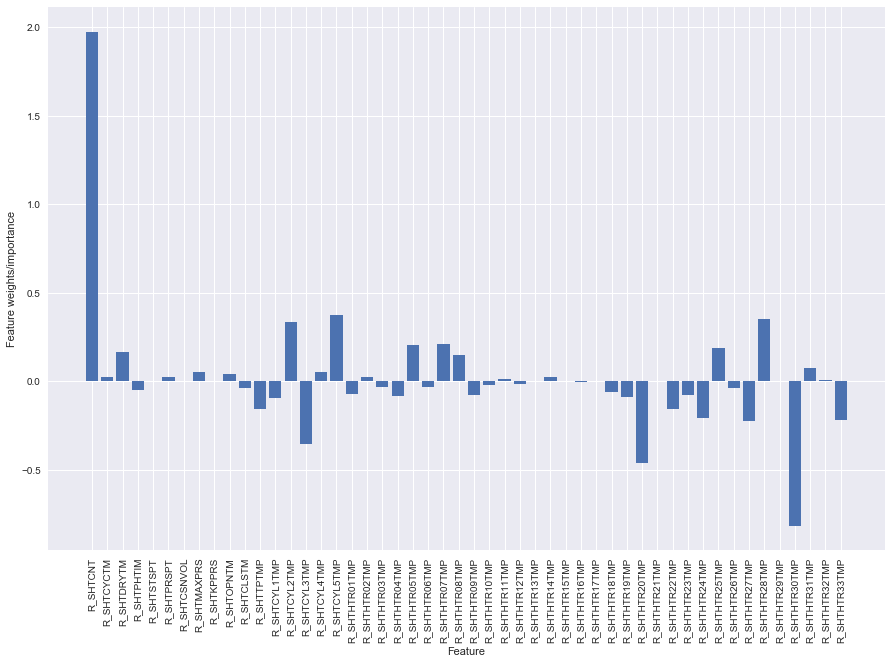

In [52]:
svc, top_features = svc_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>Analysis</strong>

In [53]:
# important features for different models
important_features

[array(['R_SHTCYL2TMP', 'R_SHTDRYTM', 'R_SHTCYL3TMP', 'R_SHTCNT',
        'R_SHTCYL5TMP'], dtype=object),
 array(['R_SHTHTR27TMP', 'R_SHTCYL2TMP', 'R_SHTDRYTM', 'R_SHTCYL5TMP',
        'R_SHTCNT'], dtype=object),
 array(['R_SHTHTR20TMP', 'R_SHTHTR27TMP', 'R_SHTHTR25TMP', 'R_SHTHTR30TMP',
        'R_SHTCNT'], dtype=object),
 array(['R_SHTCYL3TMP', 'R_SHTCYL5TMP', 'R_SHTHTR20TMP', 'R_SHTHTR30TMP',
        'R_SHTCNT'], dtype=object)]

In [54]:
flat_list = [item for sublist in important_features for item in sublist]
unique, counts = np.unique(flat_list, return_counts=True)
dict(zip(unique, counts))

{'R_SHTCNT': 4,
 'R_SHTCYL2TMP': 2,
 'R_SHTCYL3TMP': 2,
 'R_SHTCYL5TMP': 3,
 'R_SHTDRYTM': 2,
 'R_SHTHTR20TMP': 2,
 'R_SHTHTR25TMP': 1,
 'R_SHTHTR27TMP': 2,
 'R_SHTHTR30TMP': 2}

['R_SHTCNT', 'R_SHTCYL2TMP', 'R_SHTCYL3TMP', 'R_SHTCYL5TMP', 'R_SHTDRYTM', 'R_SHTHTR20TMP', 'R_SHTHTR27TMP', 'R_SHTHTR30TMP']
[1, 3, 14, 15, 17, 37, 44, 47]


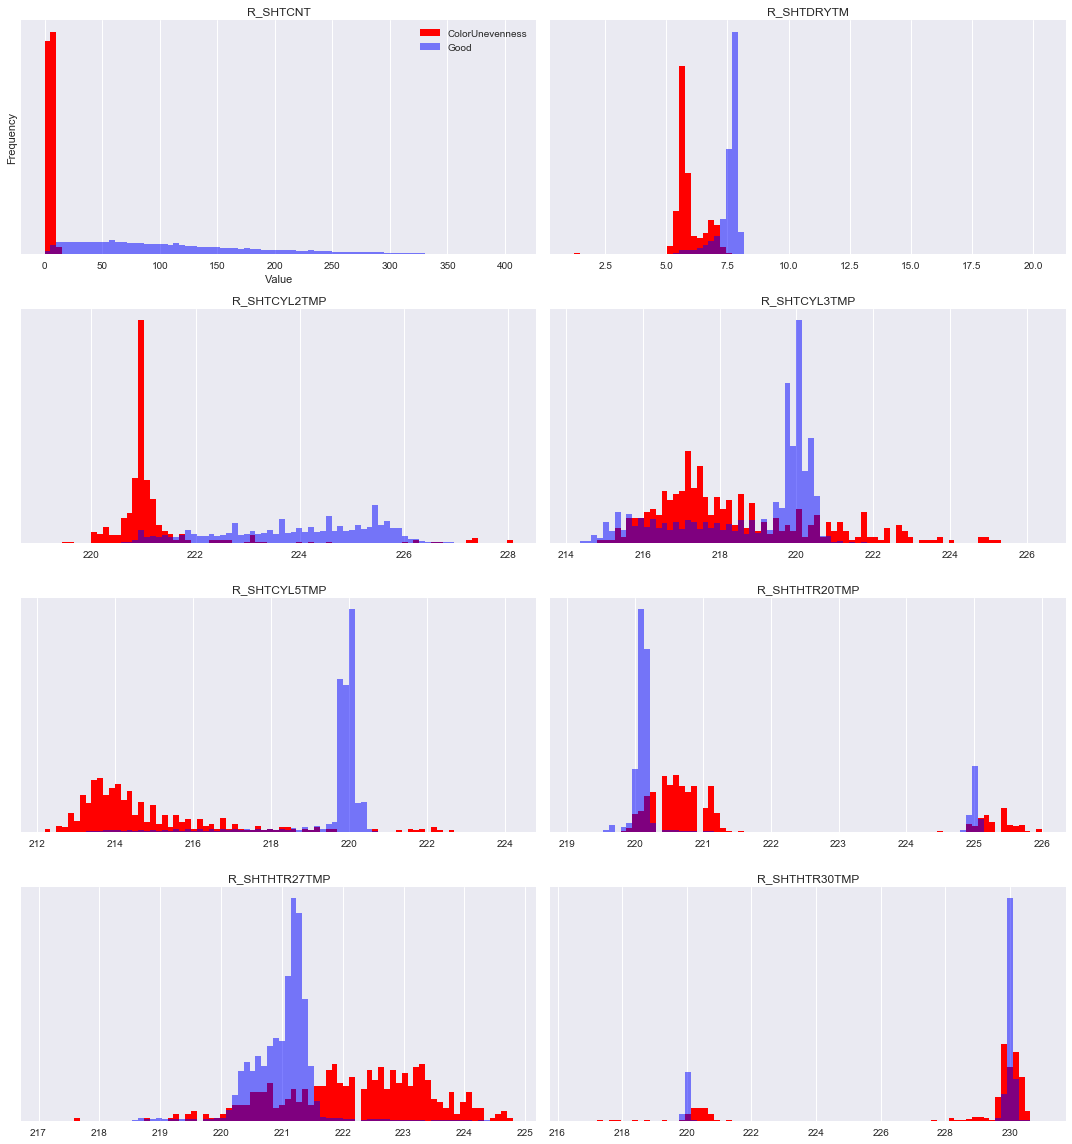

In [55]:
MIN_REPEAT = 2
analysed_features = [unique[i] for i, count in enumerate(counts) if count>=MIN_REPEAT]
print(analysed_features)

analysed_index = [data.columns.get_loc(c) for c in data.columns if c in analysed_features]
print(analysed_index)

plot_hist(data, defective, analysed_index, n_bins=80)

We can see that mean and standard deviation of features of good items are different from those of Colorunevenness items.

For 'R_SHTCNT' (first graph) - which is the number of products produced in a day. It seems that early produced products are more likely to get ColorUnevenness. Maybe, at early usage of engine, there is instability.

For other measures, I don't know what meaning of each => can't defer anything. 

### <strong>Short Defective</strong>

In [56]:
important_features = []
defective = 'Short'
i_samples, X_test, y_test = separate_data(samples, test, defective)

test size {0: 22, 1: 1000}
train size {0: 516, 1: 1000}


#### <strong>Logistic Regression</strong>

{'solver': 'newton-cg', 'C': 1}
{'solver': 'newton-cg', 'C': 2}
{'solver': 'newton-cg', 'C': 3}
{'solver': 'newton-cg', 'C': 4}
{'solver': 'lbfgs', 'C': 1}
{'solver': 'lbfgs', 'C': 2}
{'solver': 'lbfgs', 'C': 3}
{'solver': 'lbfgs', 'C': 4}
{'solver': 'sag', 'C': 1}
{'solver': 'sag', 'C': 2}
{'solver': 'sag', 'C': 3}
{'solver': 'sag', 'C': 4}
{'solver': 'saga', 'C': 1}
{'solver': 'saga', 'C': 2}
{'solver': 'saga', 'C': 3}
{'solver': 'saga', 'C': 4}
{'solver': 'liblinear', 'C': 1}


/home/nguyendinhtung/tensorflow/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:1228: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = -1.
  " = {}.".format(self.n_jobs))


{'solver': 'liblinear', 'C': 2}
{'solver': 'liblinear', 'C': 3}
{'solver': 'liblinear', 'C': 4}
Best params:  {'solver': 'lbfgs', 'C': 3}
Best Test Score 0.9866624465598488 

Confusion matrix:
 [[ 19   3]
 [ 23 977]]
Total wrong prediction: 26
Predict Short but it is Good items: 23
Predict Good, but it is Short items: 3

Top 5 features: ['R_SHTHTR10TMP' 'R_SHTHTR26TMP' 'R_SHTHTR33TMP' 'R_SHTHTR11TMP'
 'R_SHTDRYTM']


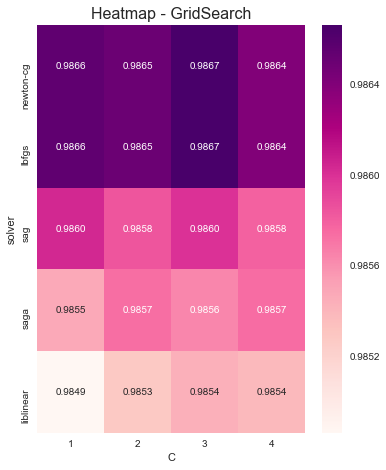

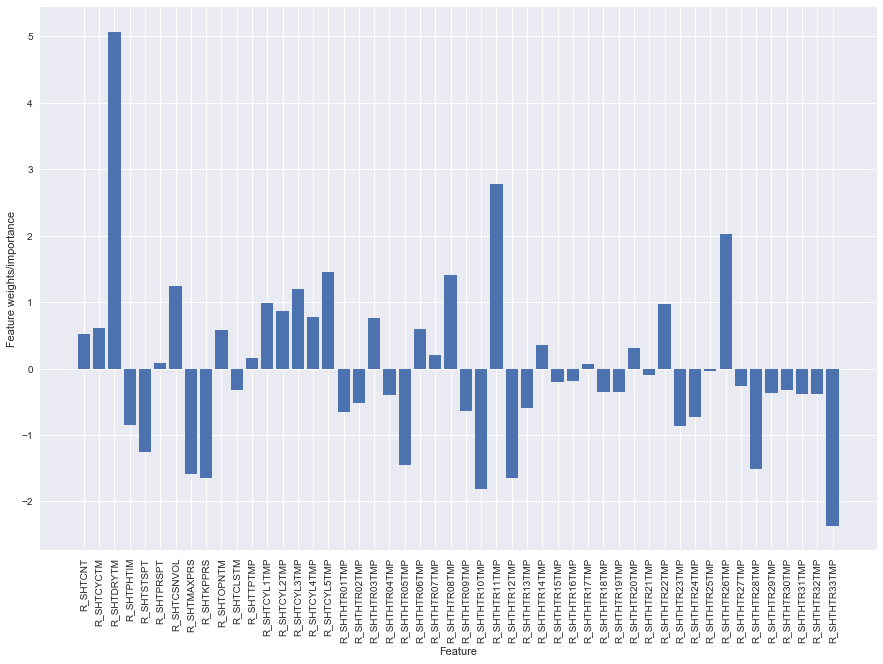

In [57]:
lr, top_features = lr_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>Random Forest</strong>

{'n': 15, 'depth': 13}
{'n': 15, 'depth': 15}
{'n': 15, 'depth': 17}
{'n': 15, 'depth': 19}
{'n': 20, 'depth': 13}
{'n': 20, 'depth': 15}
{'n': 20, 'depth': 17}
{'n': 20, 'depth': 19}
{'n': 25, 'depth': 13}
{'n': 25, 'depth': 15}
{'n': 25, 'depth': 17}
{'n': 25, 'depth': 19}
{'n': 30, 'depth': 13}
{'n': 30, 'depth': 15}
{'n': 30, 'depth': 17}
{'n': 30, 'depth': 19}
{'n': 35, 'depth': 13}
{'n': 35, 'depth': 15}
{'n': 35, 'depth': 17}
{'n': 35, 'depth': 19}
Best params:  {'n': 15, 'depth': 17}
Best Test Score 0.9894332486820719 

Confusion matrix:
 [[ 18   4]
 [ 16 984]]
Total wrong prediction: 20
Predict Short but it is Good items: 16
Predict Good, but it is Short items: 4

Top 5 features: ['R_SHTHTR33TMP' 'R_SHTTPTMP' 'R_SHTCYL4TMP' 'R_SHTCYL5TMP' 'R_SHTDRYTM']


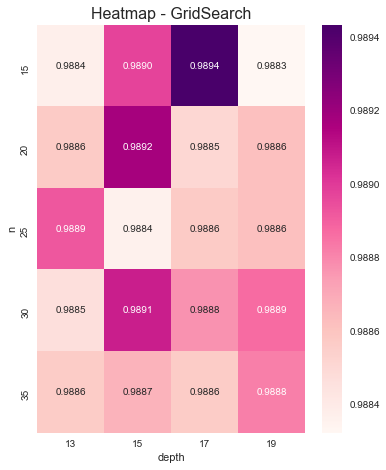

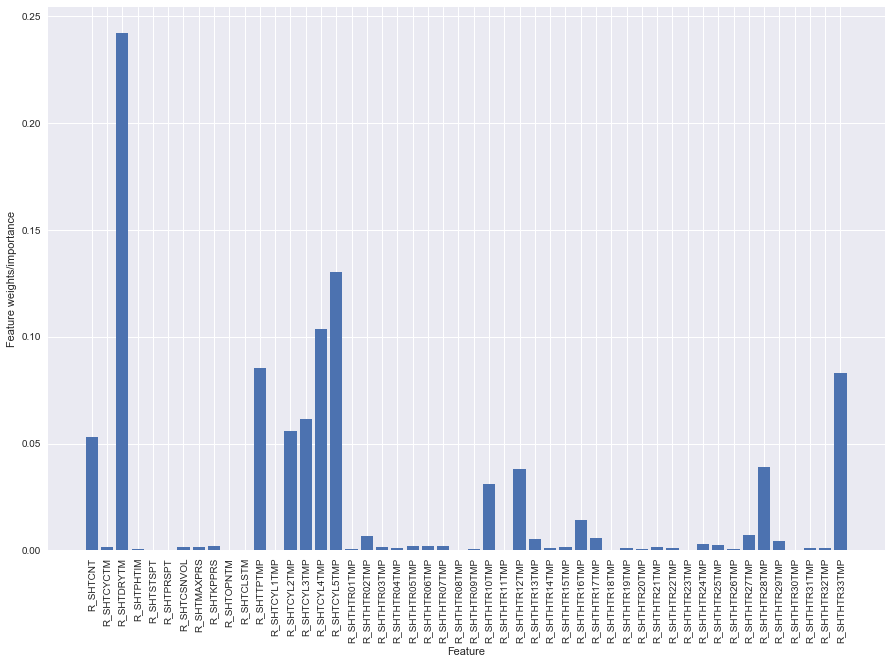

In [58]:
rf, top_features = rf_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>SGD Classifier</strong>

{'lr': 0.0001, 'average': 3}
{'lr': 0.0001, 'average': 5}
{'lr': 0.0001, 'average': 7}
{'lr': 0.0001, 'average': 9}
{'lr': 0.0001, 'average': 11}
{'lr': 0.0001, 'average': 13}
{'lr': 0.001, 'average': 3}
{'lr': 0.001, 'average': 5}
{'lr': 0.001, 'average': 7}
{'lr': 0.001, 'average': 9}
{'lr': 0.001, 'average': 11}
{'lr': 0.001, 'average': 13}
{'lr': 0.01, 'average': 3}
{'lr': 0.01, 'average': 5}
{'lr': 0.01, 'average': 7}
{'lr': 0.01, 'average': 9}
{'lr': 0.01, 'average': 11}
{'lr': 0.01, 'average': 13}
{'lr': 0.1, 'average': 3}
{'lr': 0.1, 'average': 5}
{'lr': 0.1, 'average': 7}
{'lr': 0.1, 'average': 9}
{'lr': 0.1, 'average': 11}
{'lr': 0.1, 'average': 13}
{'lr': 1.0, 'average': 3}
{'lr': 1.0, 'average': 5}
{'lr': 1.0, 'average': 7}
{'lr': 1.0, 'average': 9}
{'lr': 1.0, 'average': 11}
{'lr': 1.0, 'average': 13}
Best params:  {'lr': 0.0001, 'average': 3}
Best Test Score 0.9902151039940866 

Confusion matrix:
 [[ 15   7]
 [ 12 988]]
Total wrong prediction: 19
Predict Short but it is G

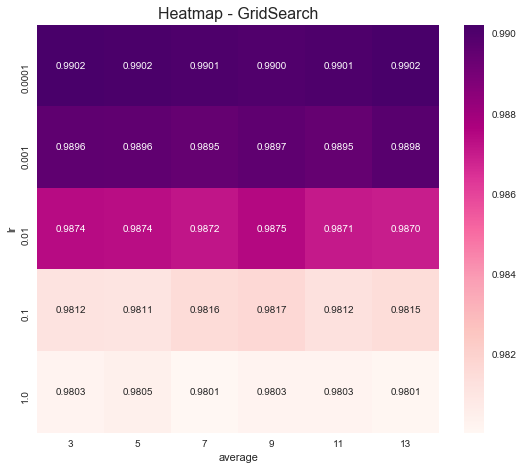

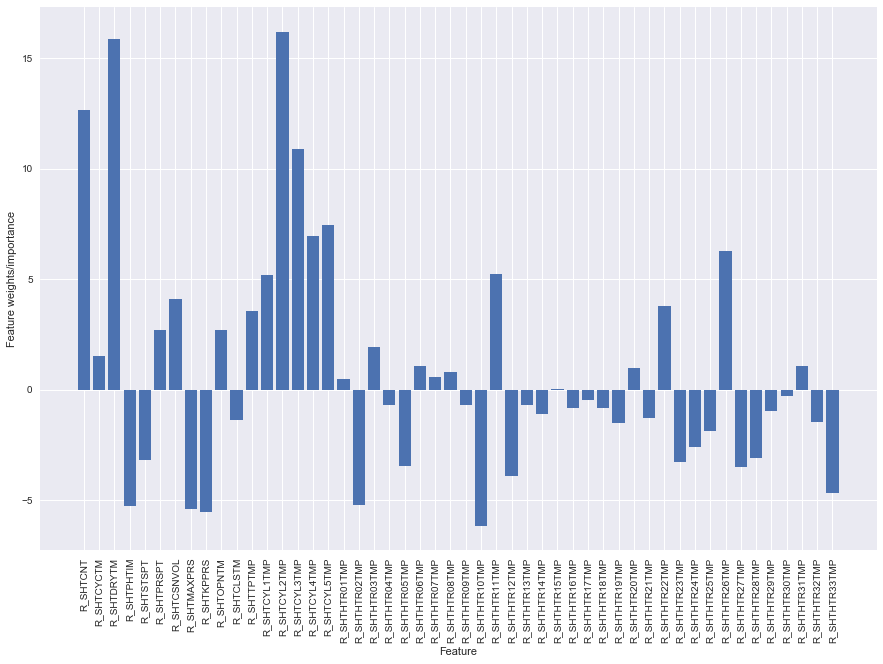

In [59]:
sgd, top_features = sgd_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>Linear SVC</strong>

{'penalty': 'l2', 'C': 0.001}
{'penalty': 'l2', 'C': 0.01}
{'penalty': 'l2', 'C': 0.1}
{'penalty': 'l2', 'C': 1.0}
{'penalty': 'l2', 'C': 10.0}
{'penalty': 'l1', 'C': 0.001}
{'penalty': 'l1', 'C': 0.01}
{'penalty': 'l1', 'C': 0.1}
{'penalty': 'l1', 'C': 1.0}
{'penalty': 'l1', 'C': 10.0}
Best params:  {'penalty': 'l1', 'C': 1.0}
Best Test Score 0.9871861841667811 

Confusion matrix:
 [[ 20   2]
 [ 21 979]]
Total wrong prediction: 23
Predict Short but it is Good items: 21
Predict Good, but it is Short items: 2

Top 5 features: ['R_SHTHTR12TMP' 'R_SHTKPPRS' 'R_SHTHTR11TMP' 'R_SHTHTR33TMP' 'R_SHTDRYTM']


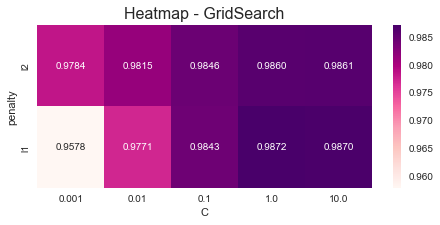

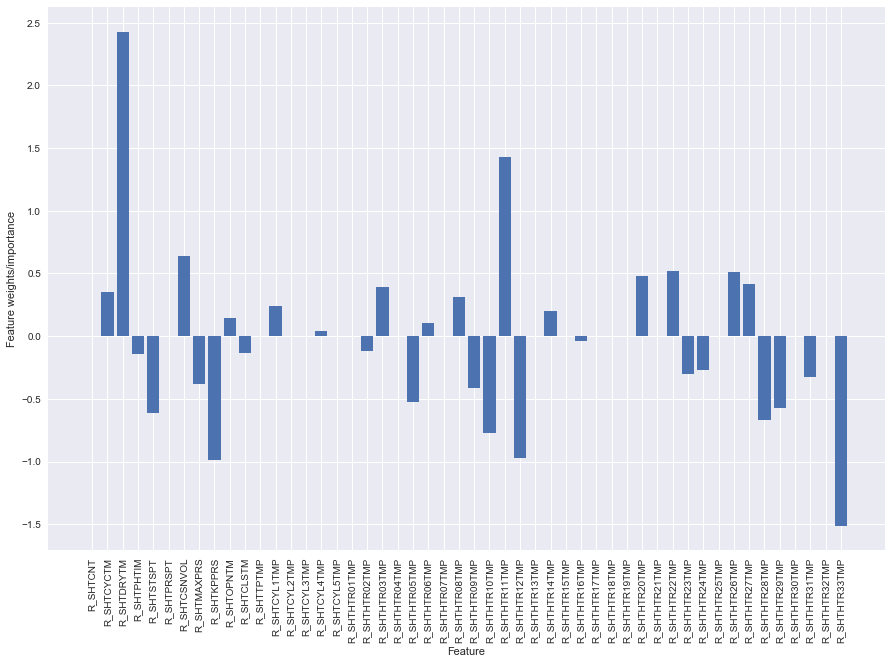

In [60]:
svc, top_features = svc_model(i_samples, X_test, y_test)
important_features.append(top_features)

#### <strong>Analysis</strong>

In [61]:
# important features for different models
important_features

[array(['R_SHTHTR10TMP', 'R_SHTHTR26TMP', 'R_SHTHTR33TMP', 'R_SHTHTR11TMP',
        'R_SHTDRYTM'], dtype=object),
 array(['R_SHTHTR33TMP', 'R_SHTTPTMP', 'R_SHTCYL4TMP', 'R_SHTCYL5TMP',
        'R_SHTDRYTM'], dtype=object),
 array(['R_SHTCYL5TMP', 'R_SHTCYL3TMP', 'R_SHTCNT', 'R_SHTDRYTM',
        'R_SHTCYL2TMP'], dtype=object),
 array(['R_SHTHTR12TMP', 'R_SHTKPPRS', 'R_SHTHTR11TMP', 'R_SHTHTR33TMP',
        'R_SHTDRYTM'], dtype=object)]

In [62]:
flat_list = [item for sublist in important_features for item in sublist]
unique, counts = np.unique(flat_list, return_counts=True)
dict(zip(unique, counts))

{'R_SHTCNT': 1,
 'R_SHTCYL2TMP': 1,
 'R_SHTCYL3TMP': 1,
 'R_SHTCYL4TMP': 1,
 'R_SHTCYL5TMP': 2,
 'R_SHTDRYTM': 4,
 'R_SHTHTR10TMP': 1,
 'R_SHTHTR11TMP': 2,
 'R_SHTHTR12TMP': 1,
 'R_SHTHTR26TMP': 1,
 'R_SHTHTR33TMP': 3,
 'R_SHTKPPRS': 1,
 'R_SHTTPTMP': 1}

['R_SHTCNT', 'R_SHTCYL2TMP', 'R_SHTCYL3TMP', 'R_SHTCYL4TMP', 'R_SHTCYL5TMP', 'R_SHTDRYTM', 'R_SHTHTR10TMP', 'R_SHTHTR11TMP', 'R_SHTHTR12TMP', 'R_SHTHTR26TMP', 'R_SHTHTR33TMP', 'R_SHTKPPRS', 'R_SHTTPTMP']
[1, 3, 9, 12, 14, 15, 16, 17, 27, 28, 29, 43, 50]


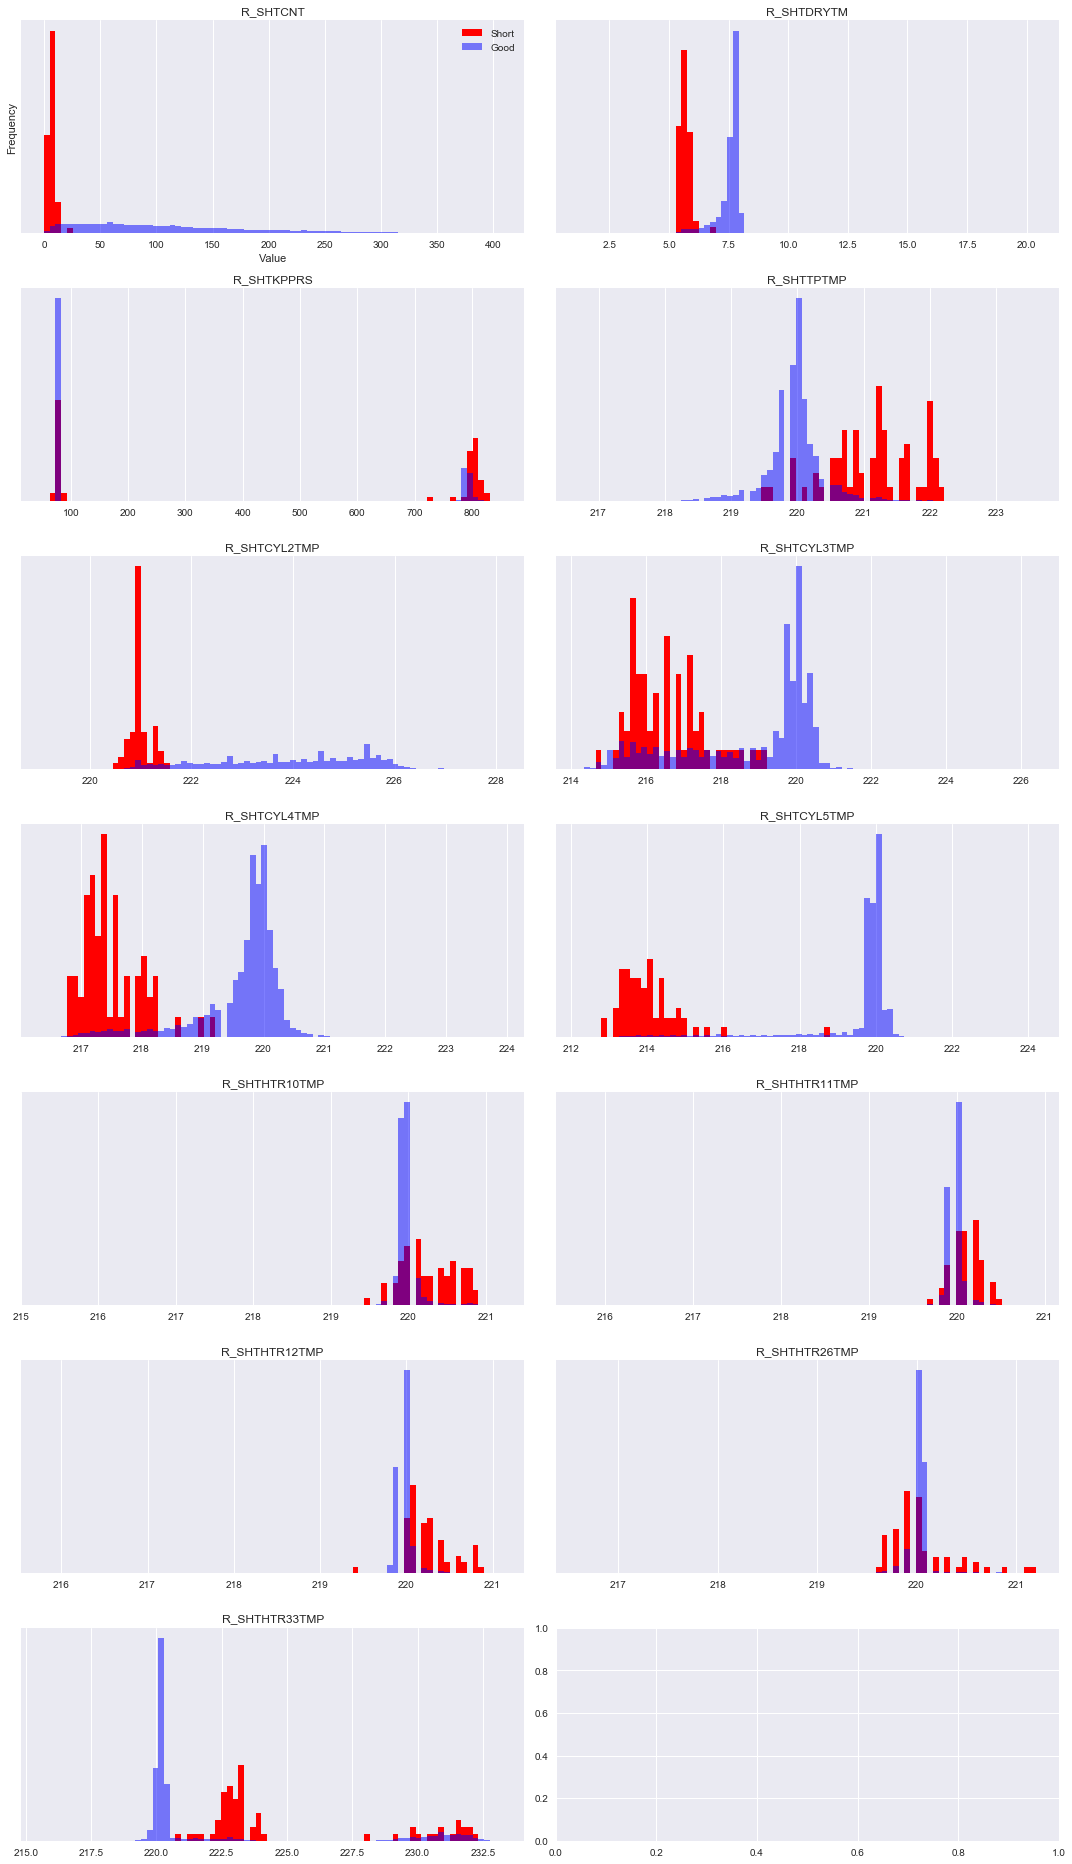

In [63]:
MIN_REPEAT = 1
analysed_features = [unique[i] for i, count in enumerate(counts) if count>=MIN_REPEAT]
print(analysed_features)

analysed_index = [data.columns.get_loc(c) for c in data.columns if c in analysed_features]
print(analysed_index)

plot_hist(data, defective, analysed_index, n_bins=80)

Those features with significant differences of mean and standard deviation between the 2 groups: Good vs Short need paying attention.

## <strong>Mera</strong>

Copy paste the same above code, we can carry out analysis for Mera. In this assignment, I will not analyze for Mera due to:<br>
1) Process is the same <br>
2) Number of Mera is too small. Out of 40688 examples, only 12 of them are Mera defective.
Due to the small number of Mera, any analysis is not significant enough to make decisions

## <strong> Multiple classification analysis </strong>
We may carray an analysis for all of defectives together. However, with that analysis, even when we know which features are important in determining results, we are unable to know if features are important for "Colorunevenness", "Mera" or "Short". Therefore, I decided not to carry out that analysis